In [1]:
import numpy as np
import pandas as pd
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [2]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

def model_metrics(y_train, y_pred_train, y_test, y_pred_test):
    print("--------Train Metrics-----------")
    print( f"rmse: \t{np.sqrt(mean_squared_error(y_train, y_pred_train)):.1e}") 
    print( f"mae: \t{mean_absolute_error(y_train, y_pred_train):.1e}")
    print(f"r2: \t{r2_score(y_train, y_pred_train):.4}" )
    print("---------Test Metrics-----------")
    print(f"rmse: \t{np.sqrt(mean_squared_error(y_test, y_pred_test)):.1e}") 
    print(f"mae: \t{mean_absolute_error(y_test, y_pred_test):.1e}") 
    print(f"r2: \t{(r2_score(y_test, y_pred_test)):.4}" )

In [3]:

df_train = pd.read_csv("data/Train.csv")
df_test = pd.read_csv("data/Test.csv")
df_valid = pd.read_csv("data/Valid.csv")
X_train = df_train.drop(["Views"],axis=1)
X_test = df_test.drop(["Views"],axis=1)
X_valid = df_valid.drop(["Views"],axis=1)
y_train = df_train["Views"]
y_test = df_test["Views"]
y_valid = df_valid["Views"]


In [4]:
sum(df_train["Views"].isna())

0

Celem jaki przyjeliśmy sobie w projekcie było przewidywanie wyświetleń utworów muzycznych na youtube. Naszym pierwotnym pomysłem było przewidywanie wyświetleń czy pomocy regresji.

<Axes: xlabel='Views', ylabel='Density'>

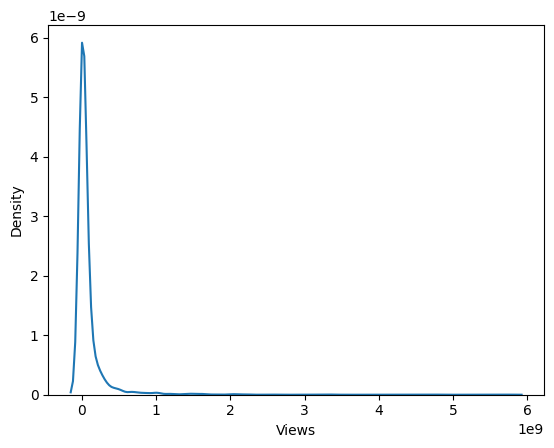

In [5]:
sns.kdeplot(y_valid)

Text(0.5, 0, 'log10(Views)')

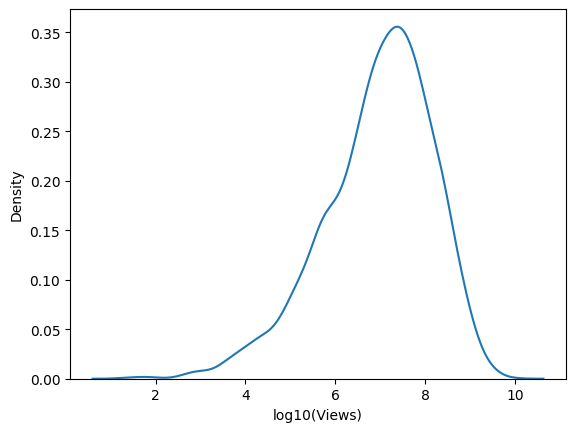

In [6]:
sns.kdeplot(np.log10(y_test), )
plt.xlabel("log10(Views)")

Jak możemy zobaczyć na powyższych wykresach przewidywana przez nas wartość ma rozkład bardzo daleki od normalnego. Rozkład przypominający go przyjmuje dopiero po zastosowaniu logarytmu.

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
model = LinearRegression()
model.fit(X_train, y_train)
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)

model_metrics(y_train, y_pred_train, y_test, y_pred_test)


Intercept: 17489502.592287228
Coefficients: [22039620.09608565 28343774.09196853 -2602990.55248665  7210418.17814586
 -5134410.11585692 -5563537.46328713  -226614.79574639 71143355.53922547
 -4587773.49164863 -3797955.44828251 12742305.55180039 14997098.84741262
 38884124.88172713 37016146.43757827 -2502180.83066631 13803380.13432659
  -331086.85574799]
--------Train Metrics-----------
rmse: 	2.7e+08
mae: 	1.2e+08
r2: 	0.05197
---------Test Metrics-----------
rmse: 	2.9e+08
mae: 	1.2e+08
r2: 	0.04922


<Axes: ylabel='Density'>

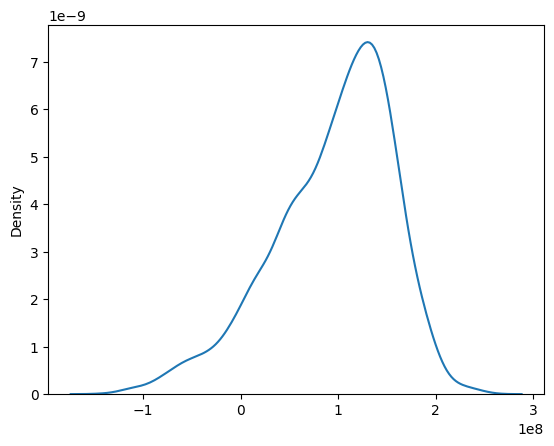

In [8]:
sns.kdeplot(y_pred_test)

W pierwszej kolejności sprawdziliśmy jak zwykły model regresji liniowej poradzi sobie z naszymi danymi. Uzyskane wyniki(Przy mednianie ~1e8 dla Views) były niezadowalające. Dodatkowo dla model miał sporo ujemnych przewidzianych wartości, które jako wyświetlenia nie mają sens, dlatego następne modele jakie wytrenowaliśmy mogą przewidywać tylko dodatnie wartości

PoissonRegressor

best model with 1 features
['Licensed']
--------Train Metrics-----------
rmse: 	2.7e+08
mae: 	1.2e+08
r2: 	0.02359
---------Test Metrics-----------
rmse: 	2.9e+08
mae: 	1.2e+08
r2: 	0.02107
---------------------------------------------
best model with 2 features
['Loudness', 'Licensed']
--------Train Metrics-----------
rmse: 	2.7e+08
mae: 	1.1e+08
r2: 	0.03843
---------Test Metrics-----------
rmse: 	2.9e+08
mae: 	1.2e+08
r2: 	0.03617
---------------------------------------------
best model with 3 features
['Danceability', 'Loudness', 'Licensed']
--------Train Metrics-----------
rmse: 	2.7e+08
mae: 	1.1e+08
r2: 	0.04462
---------Test Metrics-----------
rmse: 	2.9e+08
mae: 	1.2e+08
r2: 	0.04214
---------------------------------------------
best model with 4 features
['Danceability', 'Loudness', 'Licensed', 'new_Duration_ms']
--------Train Metrics-----------
rmse: 	2.7e+08
mae: 	1.1e+08
r2: 	0.05061
---------Test Metrics-----------
rmse: 	2.9e+08
mae: 	1.1e+08
r2: 	0.05221
---------------

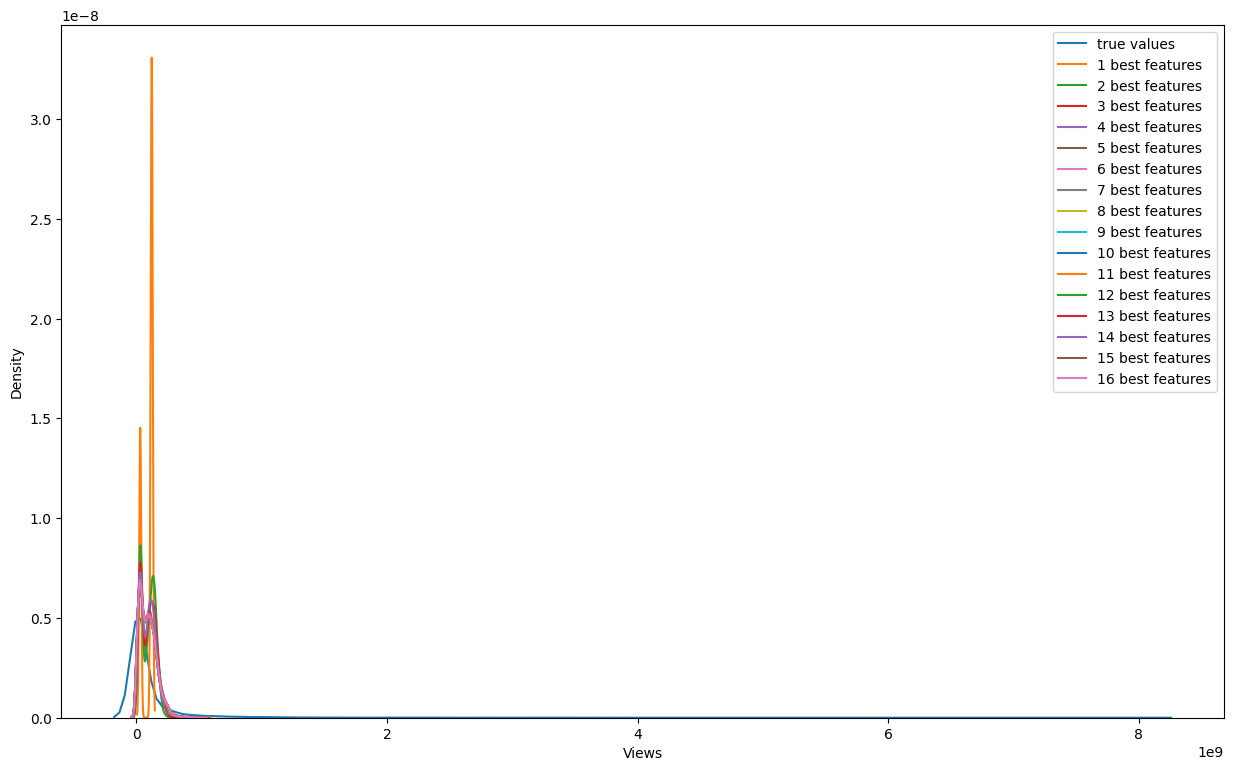

In [9]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import PoissonRegressor

model = PoissonRegressor()
model_i_featuers = [None]
features_for_i = [None]


plt.figure(figsize=(15,9))
sns.kdeplot(y_test, label = "true values")

for i in list(range(1, X_train.shape[1])):
    sfs_mae = SequentialFeatureSelector(PoissonRegressor(),
                                    n_features_to_select=i, 
                                    direction='forward',
                                    cv=5,
                                    scoring='neg_mean_squared_error')
    sfs_mae.fit(X_train, y_train)

    X_train_temp = X_train.iloc[:,sfs_mae.get_support(indices=True)]
    X_test_temp = X_test.iloc[:,sfs_mae.get_support(indices=True)]
    model_i_featuers.append(PoissonRegressor().fit(X_train_temp, y_train))
    features_for_i.append(X_test.columns[sfs_mae.get_support(indices=True)].tolist())
    
    sns.kdeplot(model_i_featuers[i].predict(X_test_temp[features_for_i[i]]), label = f"{i} best features")

    print(f"best model with {i} features")
    print(X_test.columns[sfs_mae.get_support(indices=True)].tolist())
    model_metrics(y_train,  model_i_featuers[i].predict(X_train_temp),
                  y_test,   model_i_featuers[i].predict(X_test_temp))
    print("---------------------------------------------")

plt.legend()
plt.show()






Użycie modelu przewidującego tylko pozytywne wartości i forward feature selection nie poprawiło znacząco wyników. Można zauważyć jedynie że im większa ilość najlepiej dopasowanych featurów, tym rozkład przewidzanych wartości jest bardziej podobny do rozkładu prawdziwych wartości, co jednak ma bardzo mały wpływ na inne metryki jakich używaliśmy do oceny modelu

PoissonRegressor z dropowaniem outlaierów Views w setcie treningowym

best model with 1 features
['Licensed']
--------Train Metrics-----------
rmse: 	1.4e+08
mae: 	8.2e+07
r2: 	0.04181
---------Test Metrics-----------
rmse: 	3.0e+08
mae: 	1.1e+08
r2: 	0.0118
---------------------------------------------
best model with 2 features
['Loudness', 'Licensed']
--------Train Metrics-----------
rmse: 	1.4e+08
mae: 	8.0e+07
r2: 	0.06346
---------Test Metrics-----------
rmse: 	2.9e+08
mae: 	1.1e+08
r2: 	0.02417
---------------------------------------------
best model with 3 features
['Loudness', 'Licensed', 'new_Duration_ms']
--------Train Metrics-----------
rmse: 	1.4e+08
mae: 	8.0e+07
r2: 	0.0728
---------Test Metrics-----------
rmse: 	2.9e+08
mae: 	1.1e+08
r2: 	0.02951
---------------------------------------------
best model with 4 features
['Danceability', 'Loudness', 'Licensed', 'new_Duration_ms']
--------Train Metrics-----------
rmse: 	1.3e+08
mae: 	7.9e+07
r2: 	0.0838
---------Test Metrics-----------
rmse: 	2.9e+08
mae: 	1.0e+08
r2: 	0.03635
---------------

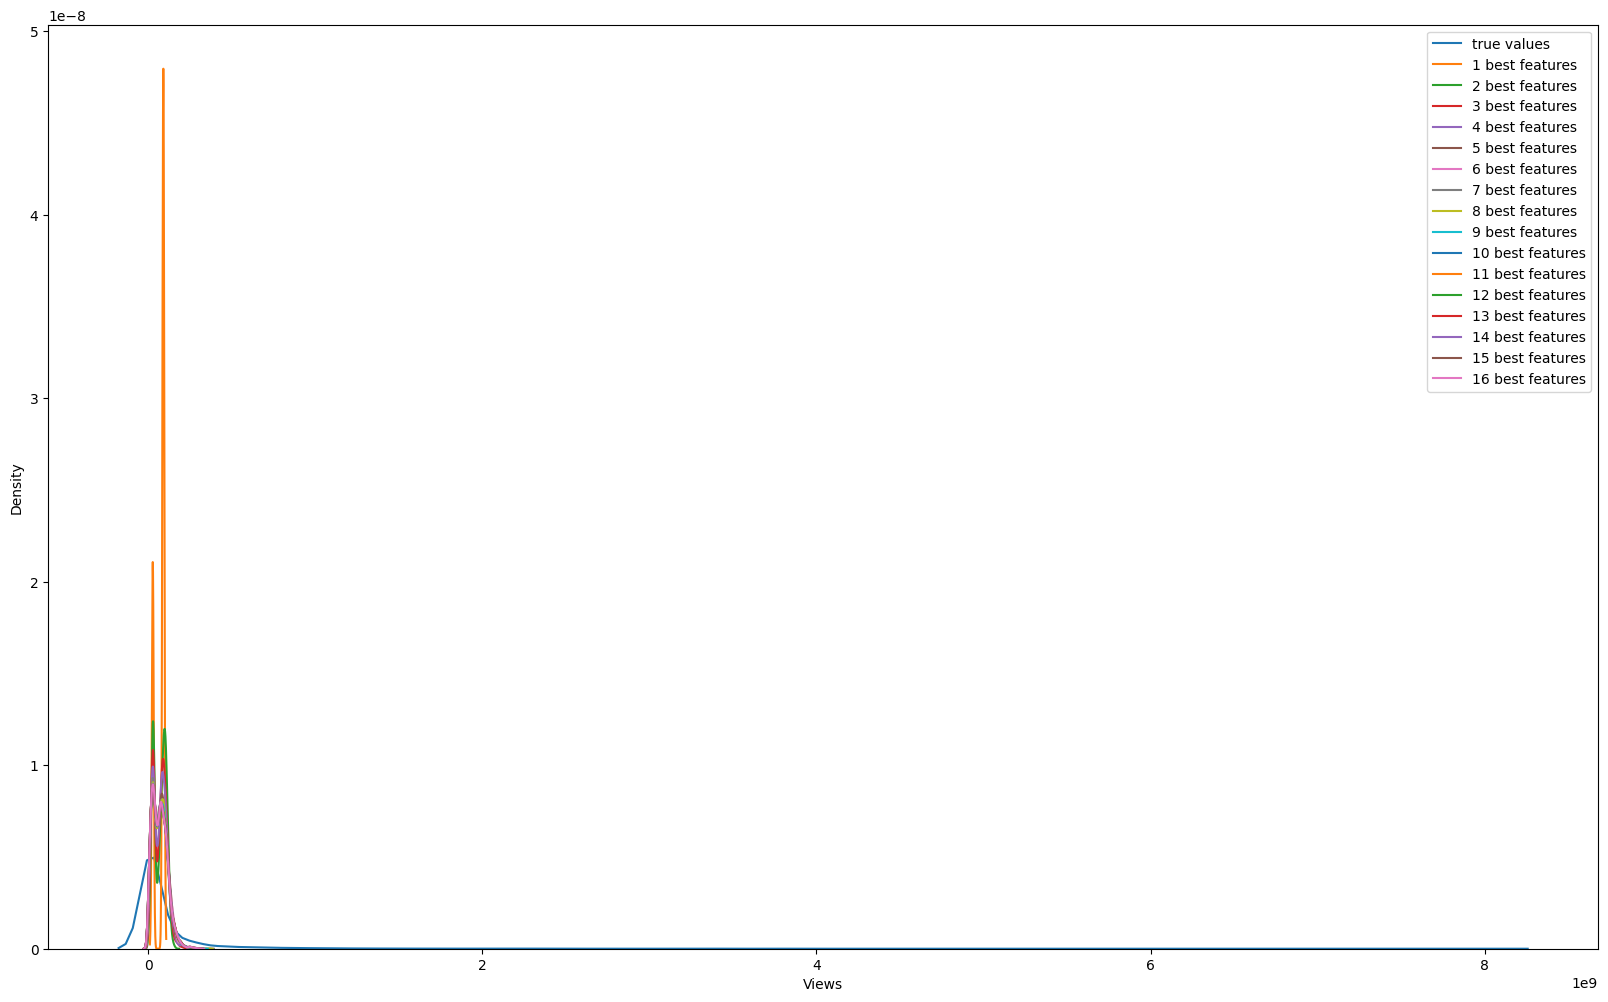

In [10]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import HuberRegressor

model = PoissonRegressor()
model_i_featuers = [None]
features_for_i = [None]

X_train_lim = X_train.loc[y_train > 1e4,:]
X_train_lim = X_train_lim.loc[y_train < 1e9,:]
y_train_lim = y_train[y_train > 1e4]
y_train_lim = y_train_lim[y_train_lim < 1e9]

plt.figure(figsize=(20,12))
sns.kdeplot(y_test, label = "true values")

for i in range(1, X_train.shape[1]):
    sfs_mae = SequentialFeatureSelector(PoissonRegressor(),
                                    n_features_to_select=i, 
                                    direction='forward',
                                    cv=5,
                                    scoring='neg_mean_squared_error')
    sfs_mae.fit(X_train_lim, y_train_lim)

    X_train_temp = X_train_lim.iloc[:,sfs_mae.get_support(indices=True)]
    X_test_temp = X_test.iloc[:,sfs_mae.get_support(indices=True)]
    model_i_featuers.append(PoissonRegressor().fit(X_train_temp, y_train_lim))
    features_for_i.append(X_test.columns[sfs_mae.get_support(indices=True)].tolist())
    
    sns.kdeplot(model_i_featuers[i].predict(X_test_temp[features_for_i[i]]), 
                   label = f"{i} best features",)

    print(f"best model with {i} features")
    print(X_test.columns[sfs_mae.get_support(indices=True)].tolist())
    model_metrics(y_train_lim,  model_i_featuers[i].predict(X_train_temp),
                  y_test,   model_i_featuers[i].predict(X_test_temp))
    print("---------------------------------------------")

plt.legend()
plt.show()

Wyrzucenie outlaierów Views z setu treningowego poprawiło wyniki modelu, ale dalej są one mocno niewystarczające 

PoissonRegressor dla log10(Views)

In [11]:
y_train_log = np.log10(y_train)
y_test_log = np.log10(y_test)

best model with 1 features
['Licensed']
--------Train Metrics-----------
rmse: 	2.9e+08
mae: 	9.1e+07
r2: 	-0.09069
---------Test Metrics-----------
rmse: 	3.1e+08
mae: 	9.2e+07
r2: 	-0.07898
---------------------------------------------
best model with 2 features
['Loudness', 'Licensed']
--------Train Metrics-----------
rmse: 	2.8e+08
mae: 	9.0e+07
r2: 	-0.07859
---------Test Metrics-----------
rmse: 	3.1e+08
mae: 	9.1e+07
r2: 	-0.06871
---------------------------------------------
best model with 3 features
['Loudness', 'Licensed', 'new_Duration_ms']
--------Train Metrics-----------
rmse: 	2.8e+08
mae: 	8.9e+07
r2: 	-0.07488
---------Test Metrics-----------
rmse: 	3.1e+08
mae: 	9.1e+07
r2: 	-0.06389
---------------------------------------------
best model with 4 features
['Loudness', 'Licensed', 'Description_Length', 'new_Duration_ms']
--------Train Metrics-----------
rmse: 	2.8e+08
mae: 	8.9e+07
r2: 	-0.06907
---------Test Metrics-----------
rmse: 	3.1e+08
mae: 	9.1e+07
r2: 	-0.0580

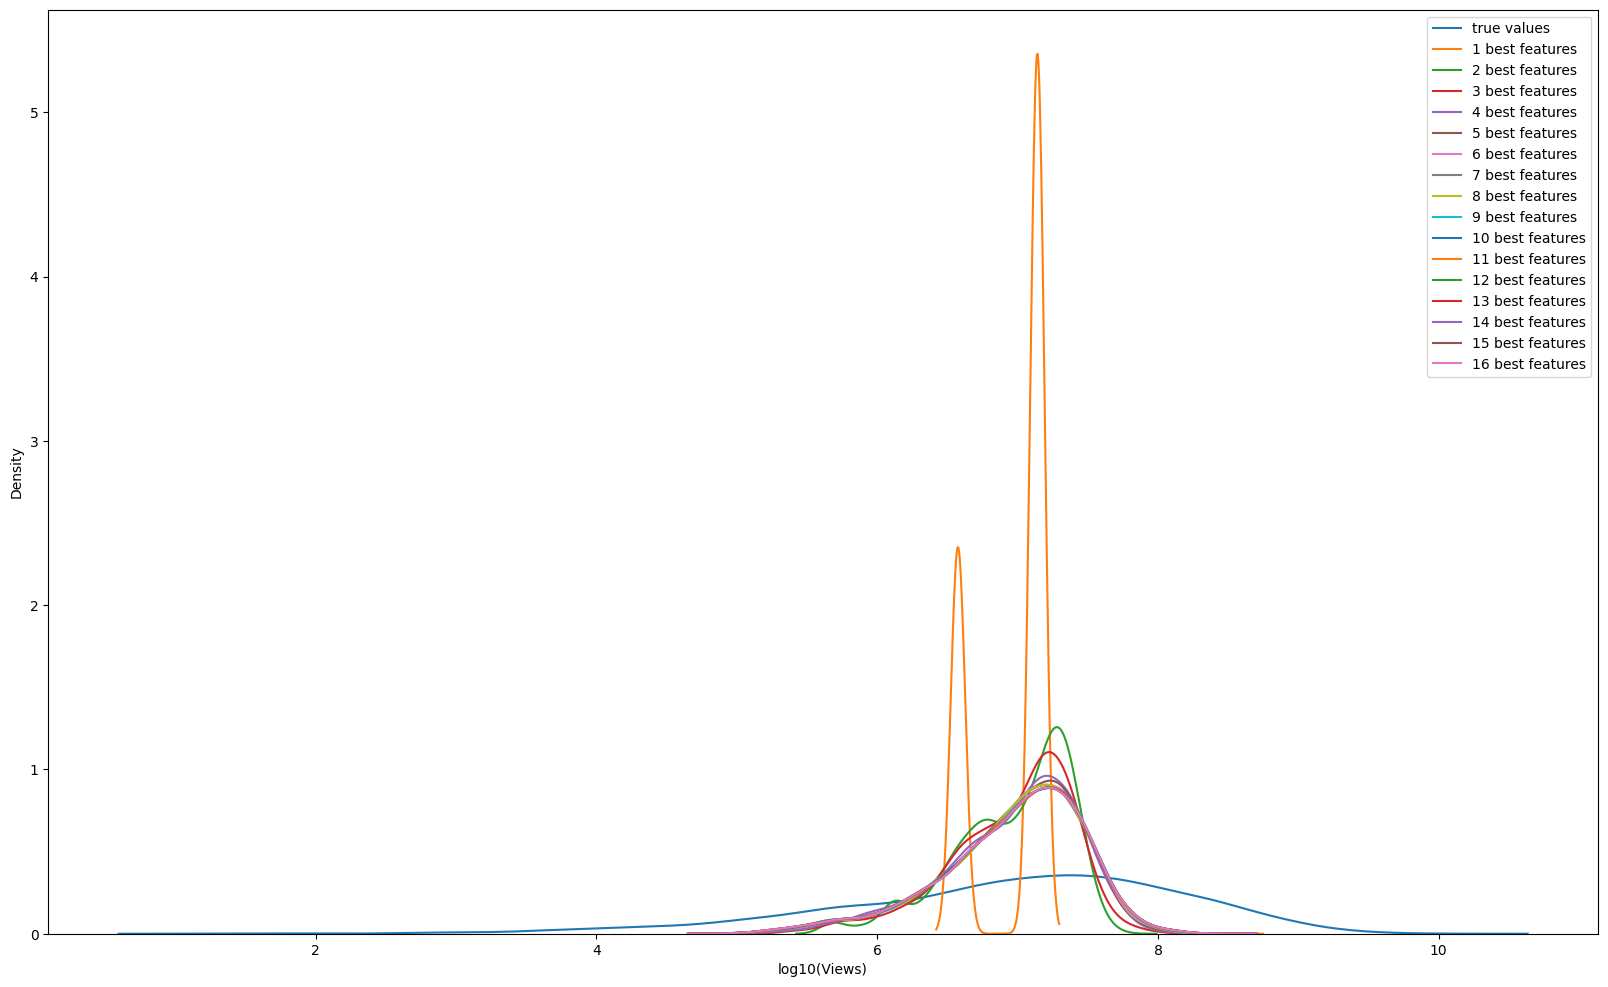

In [12]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.linear_model import HuberRegressor

model = PoissonRegressor()
model_i_featuers = [None]
features_for_i = [None]

plt.figure(figsize=(20,12))
sns.kdeplot(y_test_log, label = "true values")

for i in range(1, X_train.shape[1]):
    sfs_mae = SequentialFeatureSelector(PoissonRegressor(),
                                    n_features_to_select=i, 
                                    direction='forward',
                                    cv=5,
                                    scoring='neg_mean_squared_error')
    sfs_mae.fit(X_train, y_train_log)

    X_train_temp = X_train.iloc[:,sfs_mae.get_support(indices=True)]
    X_test_temp = X_test.iloc[:,sfs_mae.get_support(indices=True)]
    model_i_featuers.append(PoissonRegressor().fit(X_train_temp, y_train_log))
    features_for_i.append(X_test.columns[sfs_mae.get_support(indices=True)].tolist())
    
    sns.kdeplot(model_i_featuers[i].predict(X_test_temp[features_for_i[i]]), label = f"{i} best features")

    print(f"best model with {i} features")
    print(X_test.columns[sfs_mae.get_support(indices=True)].tolist())
    model_metrics(10**y_train_log,  10**model_i_featuers[i].predict(X_train_temp),
                  10**y_test_log,   10**model_i_featuers[i].predict(X_test_temp))
    print("---------------------------------------------")

plt.legend()
plt.xlabel("log10(Views)")
plt.show()

Przewidując log10(Views) nasz model miał bardzo wysokie rmse i negatywne r2, ale niższe niż dla regresjii liniowej(choć wciąć zdecydowanie zbyt wysokiego) mae. Ten model także uznajemy za niewystarczający

TweedieRegressor z forward feature selection

['Description_Length']
model index 1
--------Train Metrics-----------
rmse: 	2.7e+08
mae: 	1.2e+08
r2: 	0.01303
---------Test Metrics-----------
rmse: 	3.0e+08
mae: 	1.2e+08
r2: 	0.009164
---------------------------------------------
['Loudness', 'Description_Length']
model index 2
--------Train Metrics-----------
rmse: 	2.7e+08
mae: 	1.2e+08
r2: 	0.02626
---------Test Metrics-----------
rmse: 	2.9e+08
mae: 	1.2e+08
r2: 	0.02213
---------------------------------------------
['Loudness', 'Licensed', 'Description_Length']
model index 3
--------Train Metrics-----------
rmse: 	2.7e+08
mae: 	1.1e+08
r2: 	0.04208
---------Test Metrics-----------
rmse: 	2.9e+08
mae: 	1.2e+08
r2: 	0.03766
---------------------------------------------
['Danceability', 'Loudness', 'Licensed', 'Description_Length']
model index 4
--------Train Metrics-----------
rmse: 	2.7e+08
mae: 	1.1e+08
r2: 	0.04851
---------Test Metrics-----------
rmse: 	2.9e+08
mae: 	1.2e+08
r2: 	0.04305
-------------------------------------

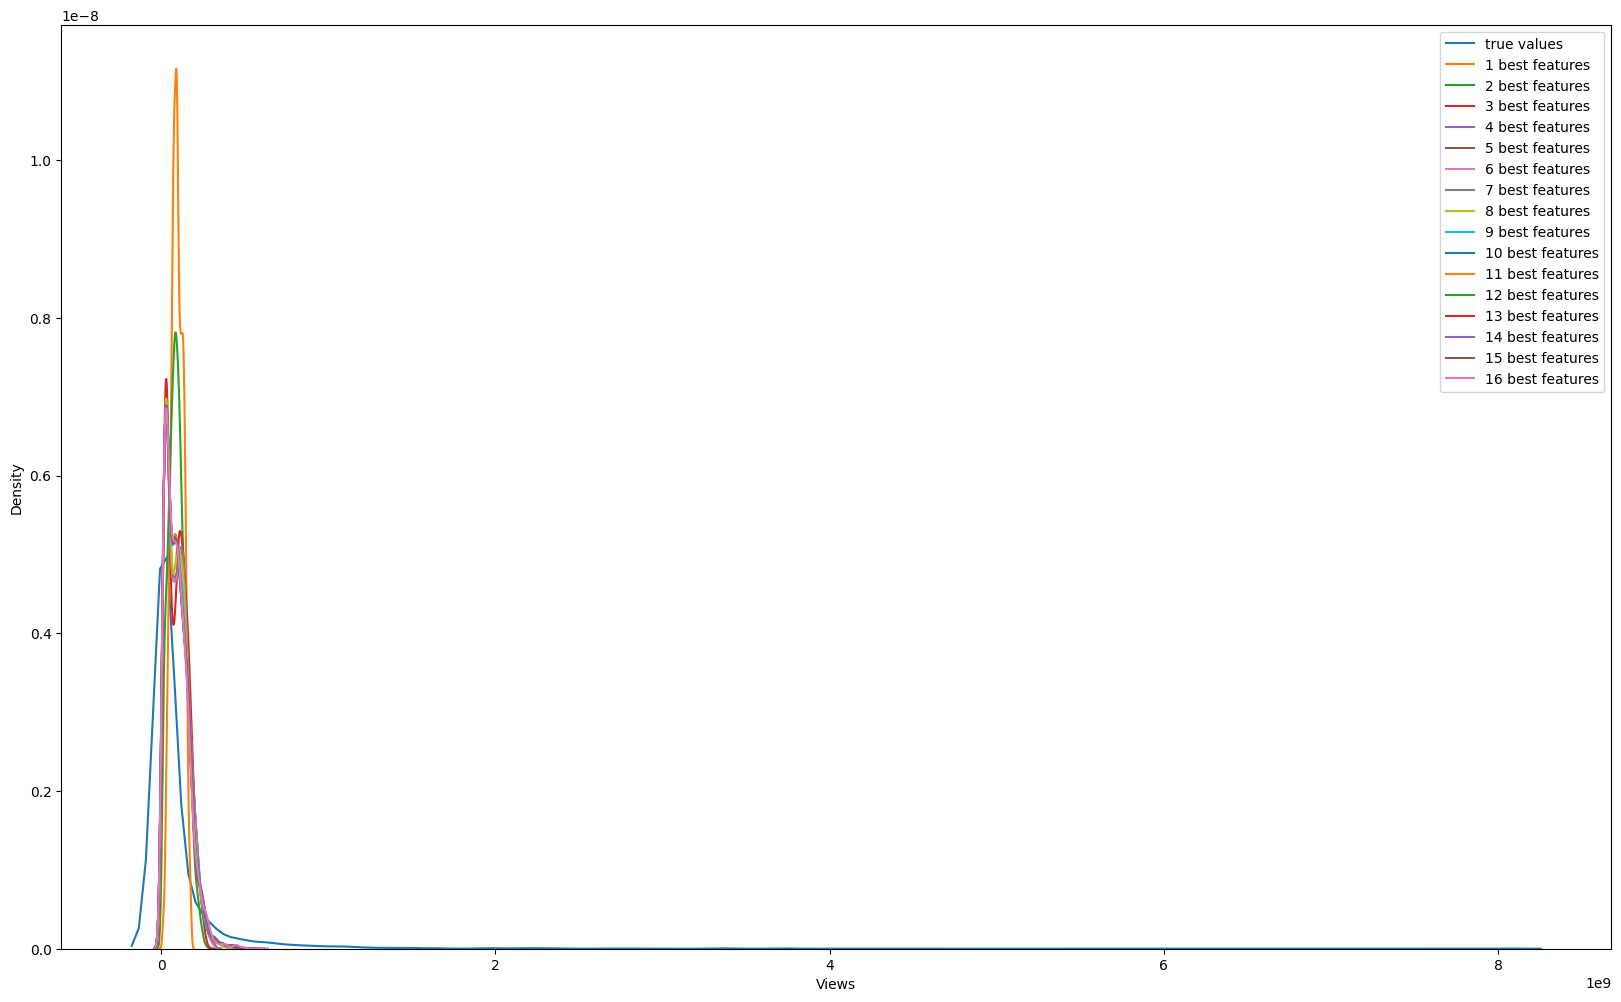

In [13]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import TweedieRegressor

model = TweedieRegressor(power=1.5)
model_i_featuers = [None]

plt.figure(figsize=(20,12))
sns.kdeplot(y_test, label = "true values")

for i in range(1, X_train.shape[1]):
    sfs_mae = SequentialFeatureSelector(TweedieRegressor(power=1.5),
                                    n_features_to_select=i, 
                                    direction='forward',
                                    cv=5,
                                    scoring='neg_median_absolute_error')
    sfs_mae.fit(X_train, y_train)
    print(X_test.columns[sfs_mae.get_support(indices=True)].tolist())
    X_train_temp = X_train.iloc[:,sfs_mae.get_support(indices=True)]
    X_test_temp = X_test.iloc[:,sfs_mae.get_support(indices=True)]
    model_i_featuers.append(TweedieRegressor(power=1.5).fit(X_train_temp, y_train))

    sns.kdeplot(model_i_featuers[i].predict(X_test_temp), label = f"{i} best features")

    print(f"model index {i}")
    model_metrics(y_train, model_i_featuers[i].predict(X_train_temp),y_test,model_i_featuers[i].predict(X_test_temp))
    print("---------------------------------------------")

plt.legend()
plt.show()

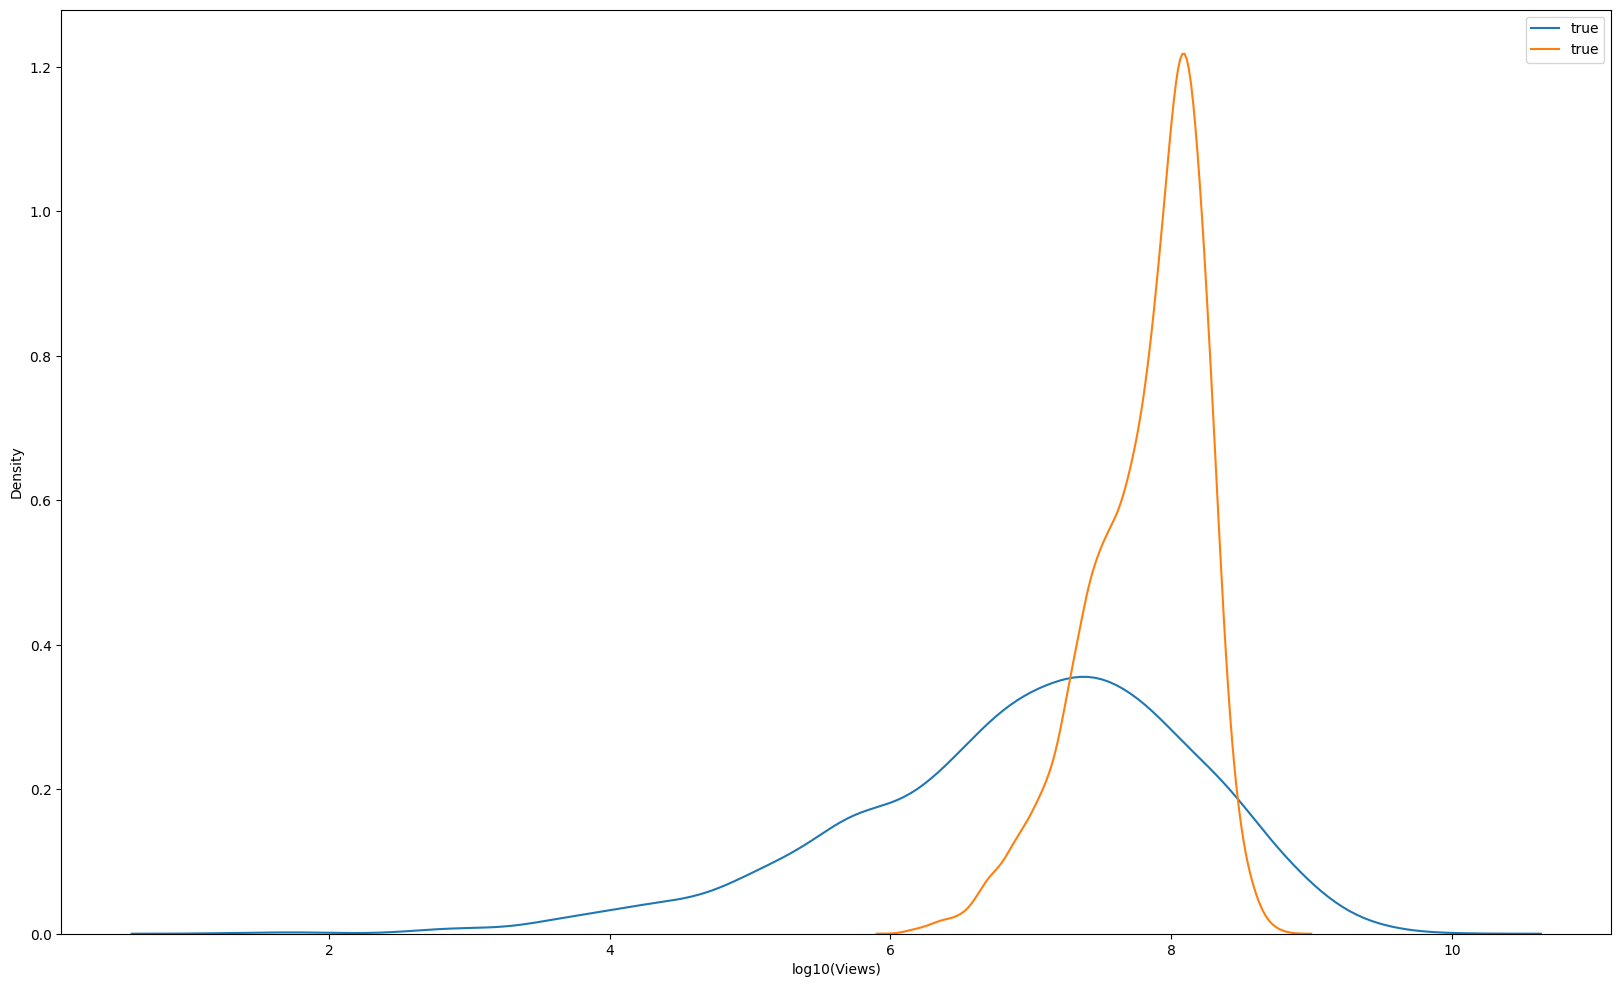

In [14]:
plt.figure(figsize=(20,12))
sns.kdeplot(np.log10(y_test), label ="true")
sns.kdeplot(np.log10(model_i_featuers[16].predict(X_train_temp)), label ="true")
plt
plt.legend()
plt.xlabel("log10(Views)")
plt.show()

Gdy zastosowaliśmy inny model wyniki regresjii dalej były nie do przyjęcia

PoissonRegressor() z tuningiem hiperparametrów przewidujący log10(Views)

--------Train Metrics-----------
rmse: 	2.8e+08
mae: 	8.8e+07
r2: 	-0.05116
---------Test Metrics-----------
rmse: 	3.0e+08
mae: 	8.9e+07
r2: 	-0.03993


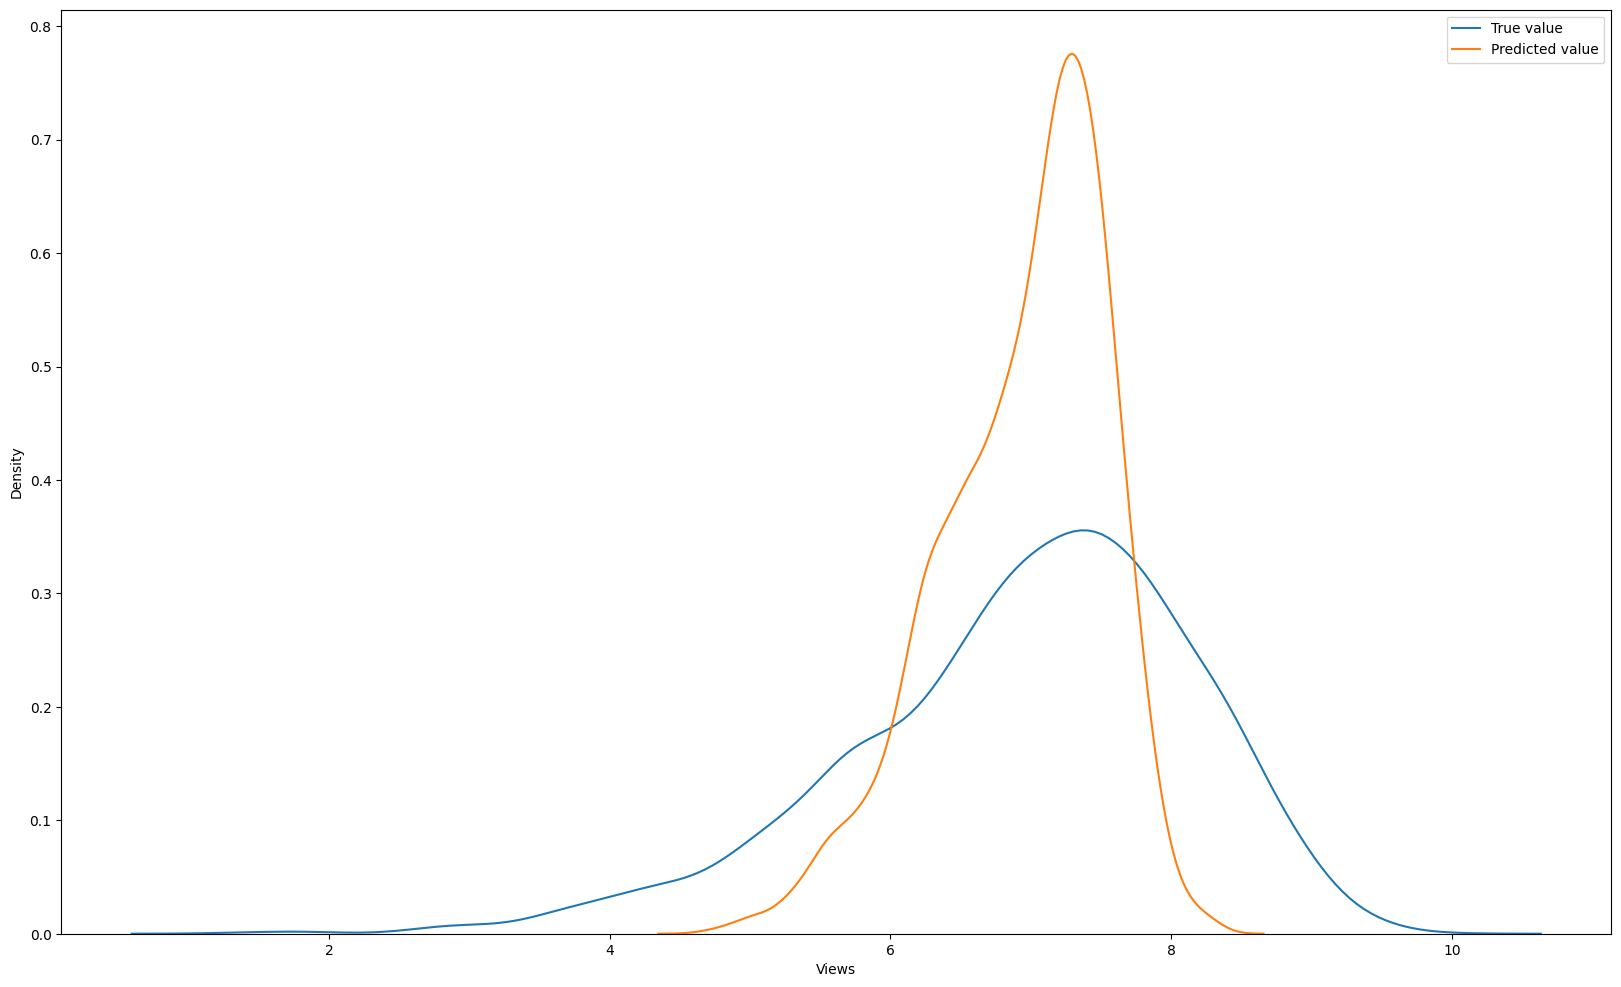

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [1e-6, 1e-4, 1e-2, 0.1, 1, 10, 100]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    PoissonRegressor(),
    param_grid,
    scoring='neg_mean_squared_error',  # or neg_mean_absolute_error
    cv=5,
    n_jobs=-1  # parallel
)
grid_search.fit(X_test, y_test_log)

model = grid_search.best_estimator_

model_metrics(10**y_train_log,10**model.predict(X_train),10**y_test_log,10** model.predict(X_test))

plt.figure(figsize=(20,12))
sns.kdeplot(y_test_log,label = "True value")
sns.kdeplot(model.predict(X_test), label = "Predicted value")
plt.legend()
plt.show()

Wyniki trenowania poissonRegressora wraz z tuningiem hiperparametrów przewidującego log10(Views) także nie dały wystarczających rezultatów, martwiące było zwłaszcza negatywne r2.

PoissonRegressor przewidujący kwantyl Views

In [16]:
y_train_reg_q =  y_train.rank(method="average")/len(y_train)
y_train_reg_q = y_train_reg_q-1e-9
y_test_reg_q = y_test.rank(method="average")/len(y_test)
y_test_reg_q = y_test_reg_q - 1e-9
model = PoissonRegressor()
model.fit(X_train, y_train_reg_q)
model_metrics(y_train_reg_q, model.predict(X_train),y_test_reg_q, model.predict(X_test))

--------Train Metrics-----------
rmse: 	2.7e-01
mae: 	2.3e-01
r2: 	0.1261
---------Test Metrics-----------
rmse: 	2.7e-01
mae: 	2.3e-01
r2: 	0.1154


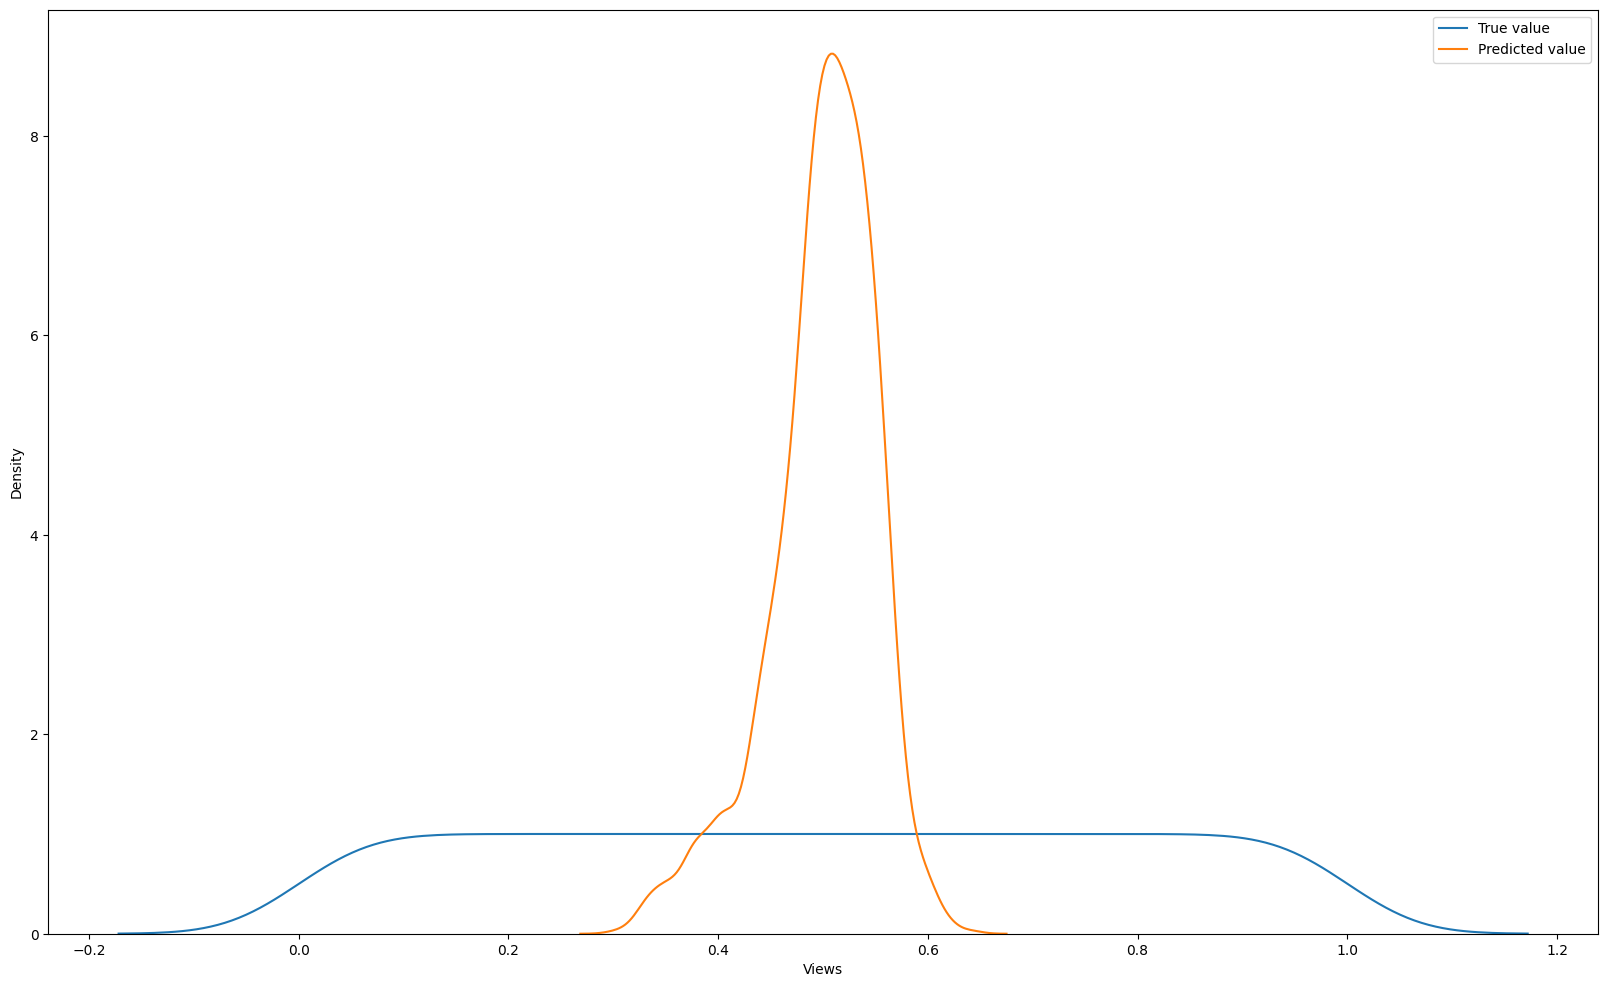

In [17]:
plt.figure(figsize=(20,12))
sns.kdeplot(y_test_reg_q,label = "True value")
sns.kdeplot(model.predict(X_test), label = "Predicted value")
plt.legend()
plt.show()

Wyniki próby przewidywania kwantylu wyświetleń okazały się owocniejsze, choć wciąż dalekie od wystarczających.

PoissonRegressor przewidujący kwantyl Views wraz z tuningiem hiperparametrów

--------Train Metrics-----------
rmse: 	2.5e-01
mae: 	2.1e-01
r2: 	0.2618
---------Test Metrics-----------
rmse: 	2.5e-01
mae: 	2.1e-01
r2: 	0.2394


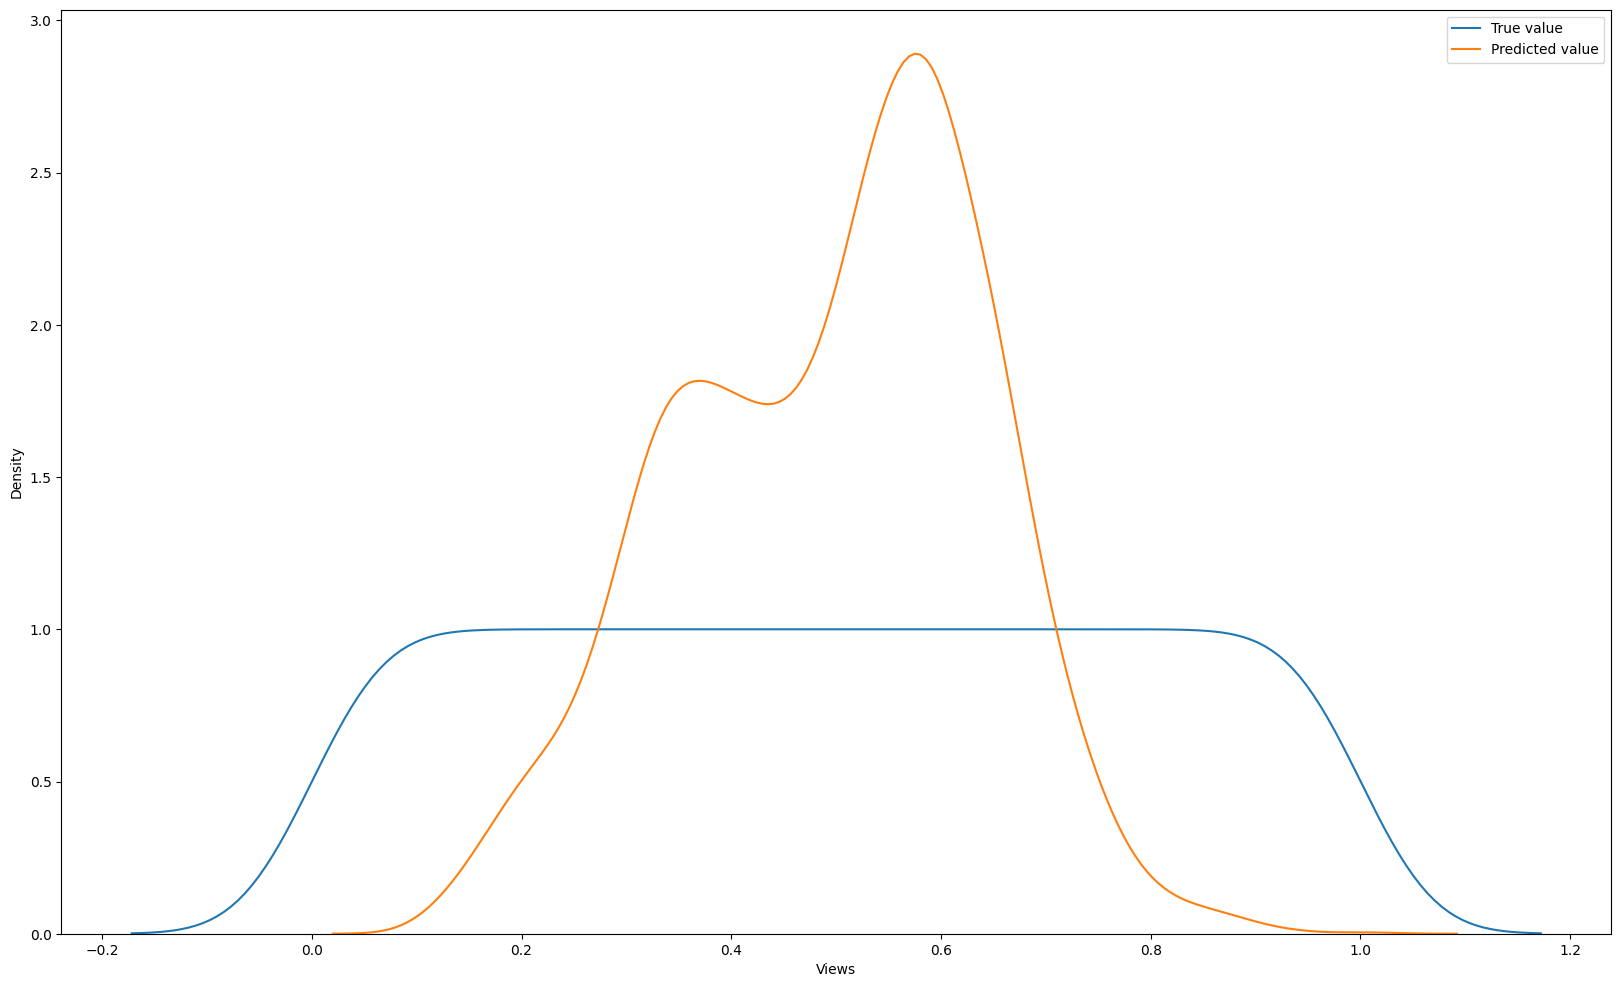

In [18]:
from sklearn.model_selection import GridSearchCV

model = PoissonRegressor()

param_grid = {
    'alpha': [1e-6, 1e-4, 1e-2, 0.1, 1, 10, 100]
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    model,
    param_grid,
    scoring='neg_mean_squared_error',  # or neg_mean_absolute_error
    cv=5,
    n_jobs=-1  # parallel
)

# Fit
grid_search.fit(X_train, y_train_reg_q)

model = grid_search.best_estimator_

model_metrics(y_train_reg_q, model.predict(X_train),y_test_reg_q, model.predict(X_test))

plt.figure(figsize=(20,12))
sns.kdeplot(y_test_reg_q,label = "True value")
sns.kdeplot(model.predict(X_test), label = "Predicted value")
plt.legend()
plt.show()



Po dodaniu tuningu hiperparametrów wszystkie sprawdzane metryki się poprawiły, w szczególności r2 się podwoił, a rozkład przewidzanych kwantyli zaczął wyglądać znacznie lepiej. Jednak rmse i ame są wciąż na tyle duże, że nie mogliśmy uznać tego modelu na wystarczający.

Teraz zmieniamy problem przewidywania Views na predykcję popularności.
Sprawdzamy wcss dla różnych ilości klastrów.

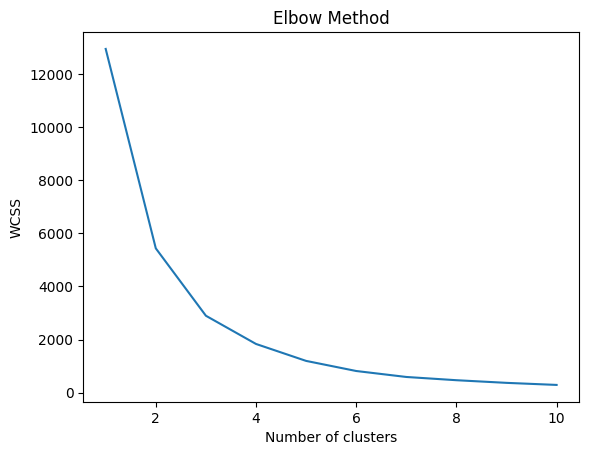

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

df_train_temp = df_train
df_test_temp = df_test
df_valid_temp = df_valid


scaler = StandardScaler()
scaler.fit(pd.DataFrame(df_train_temp.loc[:,"Views"]))
df_train_temp.loc[:,"Views_n"] = scaler.transform(pd.DataFrame(df_train_temp.loc[:,"Views"]))
df_test_temp.loc[:,"Views_n"] = scaler.transform(pd.DataFrame(df_test_temp.loc[:,"Views"]))
df_valid_temp.loc[:,"Views_n"] = scaler.transform(pd.DataFrame(df_valid_temp.loc[:,"Views"]))


wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(pd.DataFrame(df_train_temp.loc[:,"Views_n"]))
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


Dzielimy dane na 6 klastrów na bazie kolumn Views oraz sprawdzamy średnią z Views w każdym z klastrów.

In [20]:
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(pd.DataFrame(df_train_temp.loc[:,"Views_n"]))

df_train_temp["claster"] = kmeans.predict(pd.DataFrame(df_train_temp.loc[:,"Views_n"]))
df_test_temp["claster"]  = kmeans.predict(pd.DataFrame(df_test_temp.loc[:,"Views_n"]))
df_valid_temp["claster"]  = kmeans.predict(pd.DataFrame(df_valid_temp.loc[:,"Views_n"]))

(df_train_temp['Views'].groupby(df_train_temp['claster']).mean()/ 1e6).sort_values() # in millions



claster
0      24.670850
2     264.096923
4     722.635438
1    1546.323374
3    2818.455888
5    5868.088222
Name: Views, dtype: float64

Łączymy klastry tak aby sensownie podzielić dane na 3 grupy

In [21]:
name_mapper = {0:'Low-popularity', 2:'Medium-popularity', 1: 'High-popularity', 4: 'High-popularity', 3: 'High-popularity', 5:'High-popularity'}

df_train_temp['claster'] = df_train_temp['claster'].map(name_mapper)
df_test_temp['claster'] = df_test_temp['claster'].map(name_mapper)
df_valid_temp['claster'] = df_valid_temp['claster'].map(name_mapper)

In [22]:
y_train_c = df_train_temp["claster"]
y_test_c = df_test_temp["claster"]
y_valid_c = df_valid_temp["claster"]

Sprawdzamy liczności poszczególych grup popularności

In [23]:
y_train_c.value_counts()

claster
Low-popularity       10985
Medium-popularity     1414
High-popularity        557
Name: count, dtype: int64

In [24]:
y_test_c.value_counts()


claster
Low-popularity       2743
Medium-popularity     350
High-popularity       147
Name: count, dtype: int64

In [25]:
y_valid_c.value_counts()


claster
Low-popularity       3506
Medium-popularity     399
High-popularity       145
Name: count, dtype: int64

Drugi sposób badania popularności to podział ze względu na kwantyle dotyczące zmiennej Views.

In [26]:
y_train_q, bins = pd.qcut(y_train, q=3, labels=['Low','Medium',"High"],retbins=True)
bins = np.concatenate(([-np.inf], bins[1:-1], [np.inf]))
y_test_q = pd.cut(
    y_test,
    bins=bins,
    labels=['Low','Medium','High'],
    include_lowest=True
)
y_valid_q = pd.cut(
    y_valid,
    bins=bins,
    labels=['Low','Medium','High'],
    include_lowest=True
)



In [27]:
pd.DataFrame(y_valid_q).value_counts()

Views 
Medium    1417
Low       1340
High      1293
Name: count, dtype: int64

In [28]:
pd.DataFrame(y_test_q).value_counts()

Views 
Medium    1132
Low       1104
High      1004
Name: count, dtype: int64

In [29]:
pd.DataFrame(y_train_q).value_counts()

Views 
Low       4319
High      4319
Medium    4318
Name: count, dtype: int64

Enkodujemy nasz target klastrowy na zmienną numeryczną oraz tworzymy odpowiednie zbiory

In [30]:
encoderc = LabelEncoder()
encoderc.fit(y_train_c)

yc_test = encoderc.transform(y_test_c)
yc_train = encoderc.transform(y_train_c)
yc_val = encoderc.transform(y_valid_c)

Xc_train, Xc_test, Xc_valid = X_train, X_test, X_valid

Enkodujemy nasz target kwantylowy na zmienną numeryczną oraz tworzymy odpowiednie zbiory

In [31]:
encoderq = LabelEncoder()
encoderq.fit(y_train_q)

yq_test = encoderq.transform(y_test_q)
yq_train = encoderq.transform(y_train_q)
yq_val = encoderq.transform(y_valid_q)


Xq_train, Xq_test, Xq_vaild = X_train, X_test, X_valid

Pierwszy rodzaj modeli to te gdzie target jest tworzony poprzez klastrowanie i korzystamy z oversamplingu (smote)

In [32]:
### CLUSTERS with SMOTE ###

# X1, X_val, y1, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [33]:
smote = SMOTE(k_neighbors=3)
Xc_train_sm, yc_train_sm = smote.fit_resample(Xc_train, yc_train)

Sprawdzamy wyniki modeli: LogisticRegression i SVM dla sztywno ustawionych parametrów oraz Random Forest i XGBClassifier z RandomizedSearchCV, tak aby znaleźć najlepsze możliwe hiperparametry

In [34]:
from collections import Counter

In [35]:
#LogisticRegression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000)
lr.fit(Xc_train_sm, yc_train_sm)
lr_preds = lr.predict(Xc_test)

print("Logistic Regression")
print(classification_report(yc_test, lr_preds,target_names = ["High-popularity","Low-Popularity","Medium-popularity"], zero_division=0))

c:\Users\Kacper\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression
                   precision    recall  f1-score   support

  High-popularity       0.10      0.52      0.17       147
   Low-Popularity       0.93      0.60      0.73      2743
Medium-popularity       0.14      0.30      0.20       350

         accuracy                           0.56      3240
        macro avg       0.39      0.47      0.36      3240
     weighted avg       0.81      0.56      0.64      3240



In [36]:
#SVM
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
#Train a SVM model
svm = SVC(decision_function_shape='ovo')
svm.fit(Xc_train_sm, yc_train_sm)
svm_preds = svm.predict(Xc_test)
print("SVM")
print(classification_report(yc_test, svm_preds,target_names = ["High-popularity","Low-Popularity","Medium-popularity"], zero_division=0))

SVM
                   precision    recall  f1-score   support

  High-popularity       0.14      0.39      0.21       147
   Low-Popularity       0.92      0.71      0.80      2743
Medium-popularity       0.19      0.39      0.25       350

         accuracy                           0.66      3240
        macro avg       0.42      0.50      0.42      3240
     weighted avg       0.81      0.66      0.72      3240



In [37]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20, None],
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_iter=10, random_state=42, n_jobs=-1)
random_search.fit(Xc_train_sm, yc_train_sm)

best_rf_model = random_search.best_estimator_
rf_preds = best_rf_model.predict(Xc_test)

print(f"Best parameters for Random Forest: {random_search.best_params_}")
print("Random Forest - Classification Report")
print(classification_report(yc_test, rf_preds,target_names = ["High-popularity","Low-Popularity","Medium-popularity"], zero_division=0))

Best parameters for Random Forest: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': None}
Random Forest - Classification Report
                   precision    recall  f1-score   support

  High-popularity       0.30      0.33      0.31       147
   Low-Popularity       0.90      0.91      0.90      2743
Medium-popularity       0.34      0.30      0.32       350

         accuracy                           0.81      3240
        macro avg       0.51      0.51      0.51      3240
     weighted avg       0.81      0.81      0.81      3240



In [38]:
#XGBoost model with RandomizedSearchCV
xgb = XGBClassifier(objective='multi:softmax')

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'n_estimators' : [100, 200, 500],
    'objective': ['multi:softmax']
}

random_search = RandomizedSearchCV(xgb, param_grid, cv=3, scoring='accuracy')
random_search.fit(Xc_train_sm, yc_train_sm)
# random_search.fit(X1, y1)

print(random_search.best_params_)

xgb_preds = random_search.predict(Xc_test)

print("XGBoost with RandomizedSearchCV")
print(classification_report(yc_test, xgb_preds,target_names = ["High-popularity","Low-Popularity","Medium-popularity"], zero_division=0))

{'subsample': 1.0, 'objective': 'multi:softmax', 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
XGBoost with RandomizedSearchCV
                   precision    recall  f1-score   support

  High-popularity       0.26      0.27      0.27       147
   Low-Popularity       0.89      0.93      0.91      2743
Medium-popularity       0.34      0.20      0.25       350

         accuracy                           0.82      3240
        macro avg       0.50      0.47      0.48      3240
     weighted avg       0.80      0.82      0.81      3240



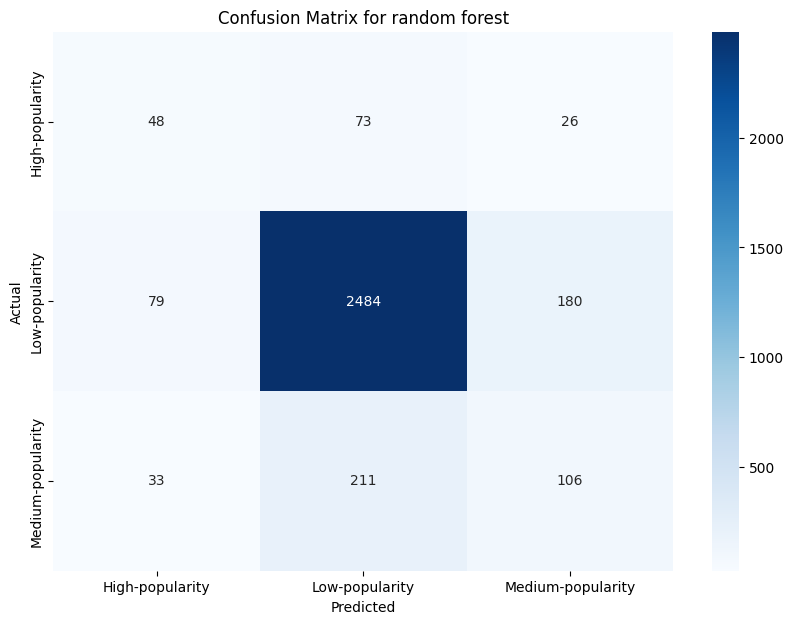

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yc_test, rf_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=encoderc.classes_, yticklabels=encoderc.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for random forest')
plt.show()

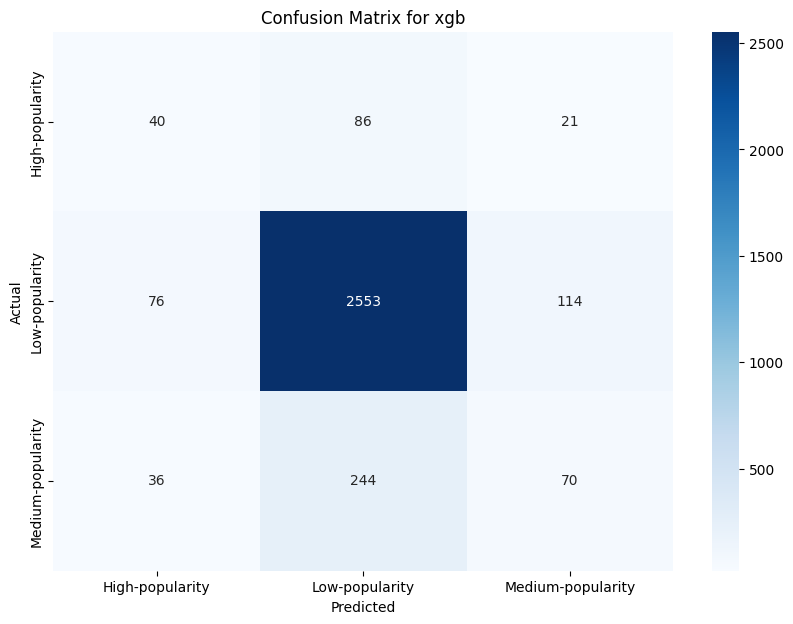

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yc_test, xgb_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=encoderc.classes_, yticklabels=encoderc.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for xgb')
plt.show()

Drugi rodzaj modeli to te gdzie target jest tworzony poprzez klastrowanie i trenujemy modele na niezbalansowanych danych

In [41]:
### CLUSTERS without SMOTE ###

Sprawdzamy wyniki modeli: LogisticRegression i SVM dla sztywno ustawionych parametrów oraz Random Forest i XGBClassifier z RandomizedSearchCV, tak aby znaleźć najlepsze możliwe hiperparametry

In [42]:
#LogisticRegression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000)
lr.fit(Xc_train, yc_train)
lr_preds = lr.predict(Xc_test)

print("Logistic Regression")
print(classification_report(yc_test, lr_preds,target_names = ["High-popularity","Low-Popularity","Medium-popularity"], zero_division=0))

Logistic Regression
                   precision    recall  f1-score   support

  High-popularity       0.00      0.00      0.00       147
   Low-Popularity       0.85      1.00      0.92      2743
Medium-popularity       0.00      0.00      0.00       350

         accuracy                           0.85      3240
        macro avg       0.28      0.33      0.31      3240
     weighted avg       0.72      0.85      0.78      3240



c:\Users\Kacper\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [43]:
#SVM
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

#Train a SVM model
svm = SVC(decision_function_shape='ovo')
svm.fit(Xc_train, yc_train)
svm_preds = svm.predict(Xc_test)
print("SVM")
print(classification_report(yc_test, svm_preds,target_names = ["High-popularity","Low-Popularity","Medium-popularity"], zero_division=0))

SVM
                   precision    recall  f1-score   support

  High-popularity       0.00      0.00      0.00       147
   Low-Popularity       0.85      1.00      0.92      2743
Medium-popularity       0.00      0.00      0.00       350

         accuracy                           0.85      3240
        macro avg       0.28      0.33      0.31      3240
     weighted avg       0.72      0.85      0.78      3240



In [44]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20, None],
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_iter=10, random_state=42, n_jobs=-1)
random_search.fit(Xc_train, yc_train)

best_rf_model = random_search.best_estimator_
rf_preds = best_rf_model.predict(Xc_test)

print(f"Best parameters for Random Forest: {random_search.best_params_}")
print("Random Forest - Classification Report")
print(classification_report(yc_test, rf_preds,target_names = ["High-popularity","Low-Popularity","Medium-popularity"], zero_division=0))

Best parameters for Random Forest: {'n_estimators': 200, 'max_features': 'log2', 'max_depth': None}
Random Forest - Classification Report
                   precision    recall  f1-score   support

  High-popularity       1.00      0.19      0.32       147
   Low-Popularity       0.86      1.00      0.93      2743
Medium-popularity       0.90      0.11      0.19       350

         accuracy                           0.87      3240
        macro avg       0.92      0.43      0.48      3240
     weighted avg       0.88      0.87      0.82      3240



In [45]:
#XGBoost model with RandomizedSearchCV
xgb = XGBClassifier(objective='multi:softmax')

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'n_estimators' : [100, 200, 500],
    'objective': ['multi:softmax']
}

random_search = RandomizedSearchCV(xgb, param_grid, cv=3, scoring='accuracy')
random_search.fit(Xc_train, yc_train)
# random_search.fit(X1, y1)

print(random_search.best_params_)

xgb_preds = random_search.predict(Xc_test)

print("XGBoost with RandomizedSearchCV")
print(classification_report(yc_test, xgb_preds,target_names = ["High-popularity","Low-Popularity","Medium-popularity"], zero_division=0))

{'subsample': 0.7, 'objective': 'multi:softmax', 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
XGBoost with RandomizedSearchCV
                   precision    recall  f1-score   support

  High-popularity       0.85      0.19      0.31       147
   Low-Popularity       0.87      0.99      0.93      2743
Medium-popularity       0.73      0.13      0.22       350

         accuracy                           0.86      3240
        macro avg       0.82      0.44      0.49      3240
     weighted avg       0.85      0.86      0.82      3240



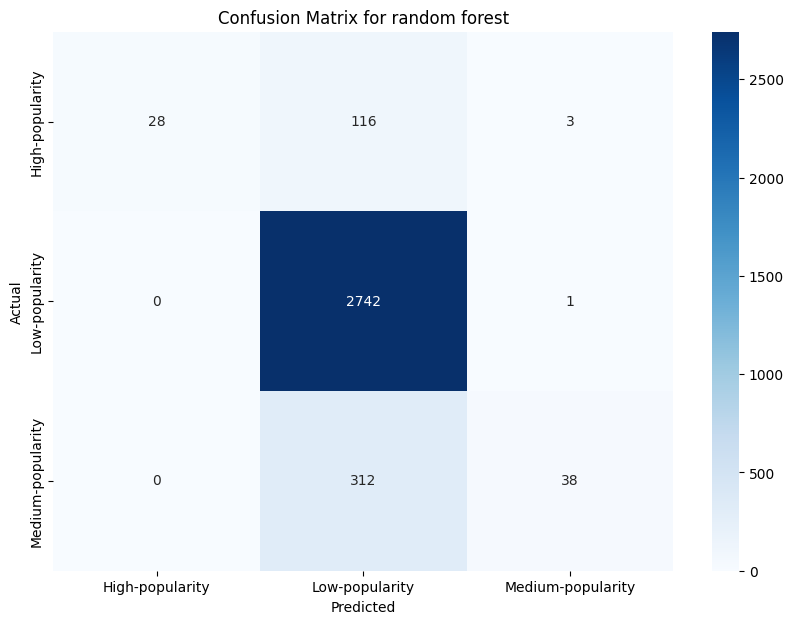

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yc_test, rf_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=encoderc.classes_, yticklabels=encoderc.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for random forest')
plt.show()

In [47]:
encoderc.classes_

array(['High-popularity', 'Low-popularity', 'Medium-popularity'],
      dtype=object)

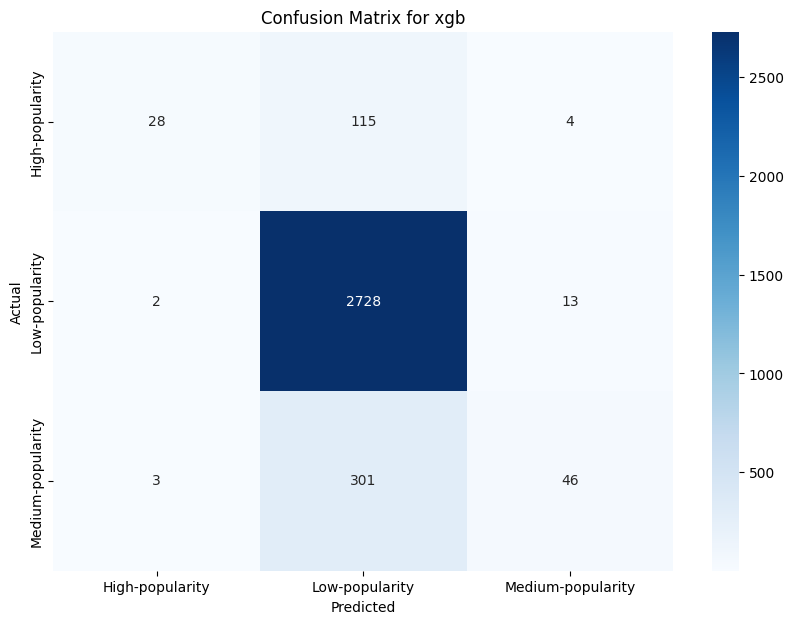

In [48]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yc_test, xgb_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=encoderc.classes_, yticklabels=encoderc.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for xgb')
plt.show()

In [49]:
pd.DataFrame(y_test_q).value_counts()

Views 
Medium    1132
Low       1104
High      1004
Name: count, dtype: int64

Trzeci rodzaj modeli to te gdzie target jest tworzony poprzez kwantyle

In [50]:
#QUARTILES

Sprawdzamy wyniki modeli: LogisticRegression i SVM dla sztywno ustawionych parametrów oraz Random Forest i XGBClassifier z RandomizedSearchCV, tak aby znaleźć najlepsze możliwe hiperparametry

In [51]:
#LogisticRegression
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs',max_iter=1000)
lr.fit(Xq_train, yq_train)
lr_preds = lr.predict(Xq_test)

print("Logistic Regression")
print(classification_report(yq_test, lr_preds,target_names=["High","Low","Medium"], zero_division=0))

Logistic Regression
              precision    recall  f1-score   support

        High       0.47      0.67      0.55      1004
         Low       0.57      0.59      0.58      1104
      Medium       0.42      0.25      0.32      1132

    accuracy                           0.50      3240
   macro avg       0.49      0.50      0.48      3240
weighted avg       0.49      0.50      0.48      3240



c:\Users\Kacper\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [52]:
#SVM
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

#Train a SVM model
svm = SVC(decision_function_shape='ovo')
svm.fit(Xq_train, yq_train)
svm_preds = svm.predict(Xq_test)
print("SVM")
print(classification_report(yq_test, svm_preds,target_names=["High","Low","Medium"], zero_division=0))

SVM
              precision    recall  f1-score   support

        High       0.51      0.68      0.58      1004
         Low       0.59      0.62      0.60      1104
      Medium       0.46      0.31      0.37      1132

    accuracy                           0.53      3240
   macro avg       0.52      0.54      0.52      3240
weighted avg       0.52      0.53      0.52      3240



In [53]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20, None],
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_iter=10, random_state=42, n_jobs=-1)
random_search.fit(Xq_train, yq_train)

best_rf_model = random_search.best_estimator_
rf_preds = best_rf_model.predict(Xq_test)

print(f"Best parameters for Random Forest: {random_search.best_params_}")
print("Random Forest - Classification Report")
print(classification_report(yq_test, rf_preds,target_names=["High","Low","Medium"], zero_division=0))

Best parameters for Random Forest: {'n_estimators': 500, 'max_features': None, 'max_depth': None}
Random Forest - Classification Report
              precision    recall  f1-score   support

        High       0.55      0.67      0.61      1004
         Low       0.61      0.63      0.62      1104
      Medium       0.50      0.39      0.44      1132

    accuracy                           0.56      3240
   macro avg       0.56      0.57      0.56      3240
weighted avg       0.56      0.56      0.55      3240



In [54]:
#XGBoost model with RandomizedSearchCV
xgb = XGBClassifier(objective='multi:softmax')

# Define hyperparameter grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'n_estimators' : [100, 200, 500],
    'objective': ['multi:softmax']
}

random_search = RandomizedSearchCV(xgb, param_grid, cv=3, scoring='accuracy')
random_search.fit(Xq_train,yq_train)
# random_search.fit(X1, y1)

print(random_search.best_params_)

xgb_preds = random_search.predict(Xq_test)

print("XGBoost with RandomizedSearchCV")
print(classification_report(yq_test, xgb_preds,target_names=["High","Low","Medium"], zero_division=0))

{'subsample': 1.0, 'objective': 'multi:softmax', 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.001, 'colsample_bytree': 0.5}
XGBoost with RandomizedSearchCV
              precision    recall  f1-score   support

        High       0.52      0.73      0.61      1004
         Low       0.61      0.64      0.63      1104
      Medium       0.51      0.30      0.38      1132

    accuracy                           0.55      3240
   macro avg       0.55      0.56      0.54      3240
weighted avg       0.55      0.55      0.53      3240



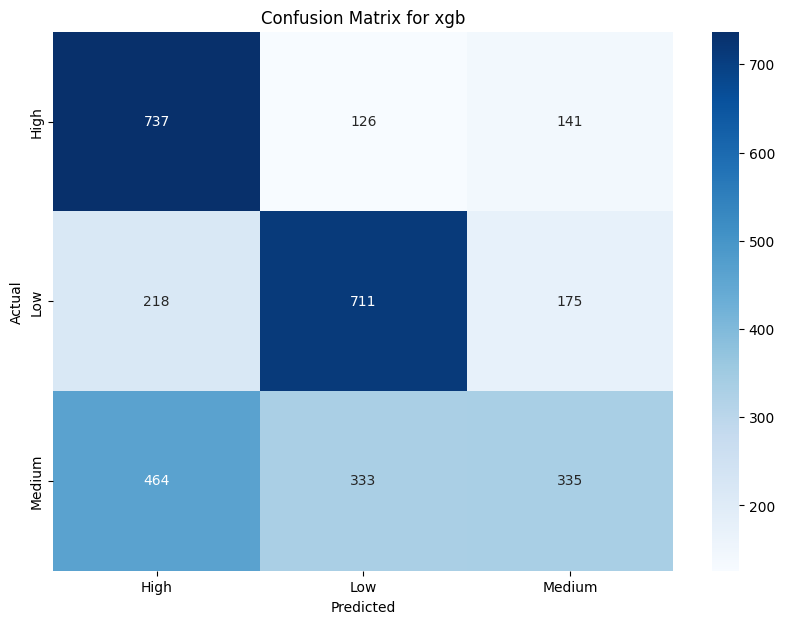

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yq_test, xgb_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=encoderq.classes_, yticklabels=encoderq.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for xgb')
plt.show()

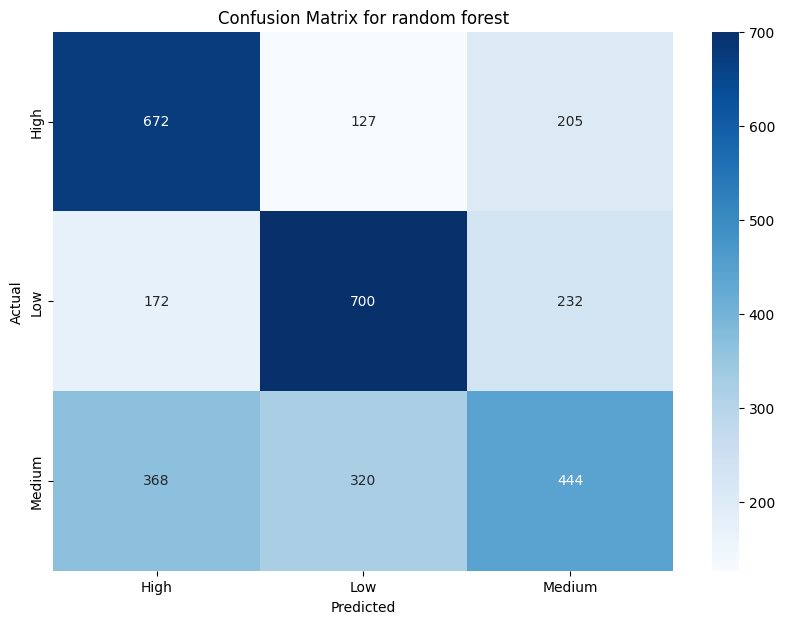

In [56]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yq_test, rf_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=encoderq.classes_, yticklabels=encoderq.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for random forest')
plt.show()